In [88]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

#將所有資料集(除ｙ_zero)讀入,進行資料整理
customer_behavior= pd.read_csv('TBN_CUST_BEHAVIOR.csv')

cc_apply = pd.read_csv('TBN_CC_APPLY.csv')

cif= pd.read_csv('TBN_CIF.csv')

fx_txn = pd.read_csv('TBN_FX_TXN.csv')

ln_apply = pd.read_csv('TBN_LN_APPLY.csv')

recent_dt = pd.read_csv('TBN_RECENT_DT.csv')

wm_txn = pd.read_csv('TBN_WM_TXN.csv')

test = pd.read_csv('TBN_Y_ZERO.csv')

In [89]:
#create train data set
train_set = pd.concat([cif, test], sort = False)
train_set = train_set.drop_duplicates(subset='CUST_NO', keep = False)
train_set = train_set.drop(['CC_IND','FX_IND', 'LN_IND', 'WM_IND'], axis =1)
train_set.head()

,CUST_NO,AGE,CHILDREN_CNT,CUST_START_DT,EDU_CODE,GENDER_CODE,INCOME_RANGE_CODE,WORK_MTHS
0,UFUIMEGMK2KTIWI4,1.0,NaN,2.0,NaN,NaN,NaN,NaN
1,3HJN2X_LGBHBKILI,3.0,0.0,9393.0,NaN,NaN,1.0,NaN
2,MNEZK2O3OE-JHYBW,4.0,0.0,2912.0,3.0,M,2.0,2.0
3,W7ADZSWYXEMHB7JQ,4.0,0.0,8332.0,5.0,M,2.0,1.0
4,ODB6BA6ORHL2UYZE,4.0,0.0,744.0,3.0,M,2.0,1.0


In [90]:
#目標: custom_id-primary key; 統計在120天內有進行什麼動作

#將ln_apply的次數存入cif, 作為y[target]
#只要在這個資料有ID, 就把target設為1，表示有借款
ln_apply_c =ln_apply.copy()

#將target欄位移到第一個
# sp0 = ln_apply_c['Target']
# ln_apply_c.drop(labels=['Target'], axis=1, inplace=True)
# ln_apply_c.insert(0, 'Target', sp0)

#因為9xxx不容易判斷, 將其調整為個位數
ln_apply_c['ln_apply_date']=ln_apply_c['TXN_DT']-9447
ln_apply_c = ln_apply_c.drop(['TXN_DT'], axis=1)

#將ln_apply_date欄位移到第一個
sp1 = ln_apply_c['ln_apply_date']
ln_apply_c.drop(labels=['ln_apply_date'], axis=1, inplace=True)
ln_apply_c.insert(1, 'ln_apply_date', sp1)

ln_apply_c = ln_apply_c.sort_values(by=['ln_apply_date'])

ln_apply_c.info()
ln_apply_c.head()

ln_apply_c.head()
#[??]想依照時間順序畫圖
#[??]如果是使用時間, cust_no會重複, 如何跟cif整合？->ans. 出現兩筆以上的cust_id沒關係, 但可以等預測完後, 再把重複的cust_id drop 掉
# 先不把ln_count算進去好了

#確認重複數值
#pd.concat(g for _, g in ln_apply_c.groupby("CUST_NO") if len(g) > 1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6741 entries, 1510 to 1672
Data columns (total 4 columns):
CUST_NO          6741 non-null object
ln_apply_date    6741 non-null int64
LN_AMT           6741 non-null int64
LN_USE           6741 non-null object
dtypes: int64(2), object(2)
memory usage: 263.3+ KB


,CUST_NO,ln_apply_date,LN_AMT,LN_USE
1510,XK7H30QEQHA1THZO,2,848097,07
1483,HBJ5THQOPDNDUVBK,2,879483,04
1472,W6E7SXSKHLYWFAR4,2,828864,14
69,_MWML2ILT12UGCRG,2,739437,05
199,O2Y9ZCCZW2XBOMKM,2,1022428,07


In [91]:
ln_apply_c['target_60']=0
ln_apply_c['target_60'][(ln_apply_c['ln_apply_date'] > 30) & (ln_apply_c['ln_apply_date'] <= 60)] = 1
ln_apply_c['target_90']=0
ln_apply_c['target_90'][(ln_apply_c['ln_apply_date'] > 60) & (ln_apply_c['ln_apply_date'] <= 90)] = 1
ln_apply_c['target_120']=0
ln_apply_c['target_120'][(ln_apply_c['ln_apply_date'] > 90) & (ln_apply_c['ln_apply_date'] <= 120)] = 1
#     elif ln_apply_c[(ln_apply_c['ln_apply_date'] <=90)]:
#         ln_apply_c['Target_90']=1
#     elif ln_apply_c[(ln_apply_c['ln_apply_date'] <=120)]:
#         ln_apply_c['Target_120']=1
#ln_apply_c['Target_60'] = ln_apply_c[(ln_apply_c['ln_apply_date']>30) &(ln_apply_c['ln_apply_date']<=60)]
ln_apply_c.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,CUST_NO,ln_apply_date,LN_AMT,LN_USE,target_60,target_90,target_120
1510,XK7H30QEQHA1THZO,2,848097,07,0,0,0
1483,HBJ5THQOPDNDUVBK,2,879483,04,0,0,0
1472,W6E7SXSKHLYWFAR4,2,828864,14,0,0,0
69,_MWML2ILT12UGCRG,2,739437,05,0,0,0
199,O2Y9ZCCZW2XBOMKM,2,1022428,07,0,0,0


In [92]:
#用join終於把兩個表結合再一起了, 不知道爲什麼用concat會全部變成na
# ln_data_2 = pd.concat([ln_apply_c, pd.get_dummies(ln_apply_c.iloc[:,1], prefix='day', columns=['ln_apply_date'])],axis = 1)
#a = a.reset_index()
#ln_data_2.head()
ln_data_3 = ln_apply_c.groupby('CUST_NO').agg('sum') #已經將各天相加
ln_data_3.reset_index()
#ln_data_3.head()

#a.to_csv('ln_date.csv', index= False)
#pd.concat(g for _, g in ln_data_3.groupby("CUST_NO") if len(g) > 1)

,CUST_NO,ln_apply_date,LN_AMT,target_60,target_90,target_120
0,--OUUIAZZHUX-G58,44,777569,1,0,0
1,--_OGJJSDWXZDF7G,82,925966,0,1,0
2,-1D9VBLTGBVOWGVK,108,1139478,0,0,1
3,-1HUKIBVJ-KGKOZU,87,848097,0,1,0
4,-1V5YVOHU4MRXNZO,26,805996,0,0,0
5,-2DPV7LV1CKCEFXI,85,848097,0,1,0
6,-2JETLOIT2WLFXVI,30,892709,0,0,0
7,-2OG-Z-JBNTWCIOQ,109,777569,0,0,1
8,-3TAWCZ1OHDAO9MQ,108,848097,0,0,1
9,-3WN3QQOSUM2LD2G,100,904731,0,0,1


In [93]:
ln_r=pd.merge(test, ln_data_3, on ='CUST_NO', how = 'left')
ln_r=ln_r.drop(['CC_IND', 'FX_IND', 'LN_IND', 'WM_IND'], axis =1)
ln_r.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 29999
Data columns (total 6 columns):
CUST_NO          30000 non-null object
ln_apply_date    406 non-null float64
LN_AMT           406 non-null float64
target_60        406 non-null float64
target_90        406 non-null float64
target_120       406 non-null float64
dtypes: float64(5), object(1)
memory usage: 1.6+ MB


In [94]:
#create train set
ln_r_train = pd.merge(train_set, ln_data_3, on ='CUST_NO', how = 'left')
ln_r_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157971 entries, 0 to 157970
Data columns (total 13 columns):
CUST_NO              157971 non-null object
AGE                  157825 non-null float64
CHILDREN_CNT         157468 non-null float64
CUST_START_DT        157825 non-null float64
EDU_CODE             133411 non-null float64
GENDER_CODE          156166 non-null object
INCOME_RANGE_CODE    157508 non-null float64
WORK_MTHS            127379 non-null float64
ln_apply_date        2227 non-null float64
LN_AMT               2227 non-null float64
target_60            2227 non-null float64
target_90            2227 non-null float64
target_120           2227 non-null float64
dtypes: float64(11), object(2)
memory usage: 16.9+ MB


In [95]:
cc_apply.info()
cc_number = cc_apply.copy()
#cc_number['date']= cc_number['TXN_DT']-9447
cc_number = cc_number.drop(['TXN_DT'], axis=1)

cc_number.info()
cc_number['cc_apply_c']=1

#cc_number_1 = pd.concat([cc_number, pd.get_dummies(cc_number.iloc[:,1], prefix='day', columns=['date'])],axis = 1)
#cc_number_1=cc_number_1.drop(labels=['date'], axis=1)
#cc_number_1.head()

cc_number_2 = cc_number.groupby('CUST_NO').agg('sum') #已經將各天相加
cc_number_2.reset_index()

#sp2 = cc_number['ln_apply_date']
#cc_number.drop(labels=['ln_apply_date'], axis=1, inplace=True)
#cc_number.insert(1, 'ln_apply_date', sp2)
#cc_number.info()
#cc_number.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54393 entries, 0 to 54392
Data columns (total 2 columns):
CUST_NO    54393 non-null object
TXN_DT     54393 non-null int64
dtypes: int64(1), object(1)
memory usage: 850.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54393 entries, 0 to 54392
Data columns (total 1 columns):
CUST_NO    54393 non-null object
dtypes: object(1)
memory usage: 425.0+ KB


,CUST_NO,cc_apply_c
0,---CHVW7DUN8SZLO,2
1,--37ZQ9XGUMXZASK,1
2,--55JSAQ0THV0RMA,1
3,--AEHX30X32VHK3Y,1
4,--AKTEGTKD38U3BY,1
5,--D7UB97FGKNOMVC,1
6,--DWAILGE3XOI2W8,1
7,--KEX0HYP72TSBOQ,1
8,--ONGLWHY32XCGQQ,1
9,--RW6XQMCPW_UQU4,1


In [97]:
pd.set_option('display.max_columns',None)

cc_ln_r = pd.merge(ln_r, cc_number_2, on = 'CUST_NO', how = 'left')

cc_ln_r.head()

,CUST_NO,ln_apply_date,LN_AMT,target_60,target_90,target_120,cc_apply_c
0,_PT5HFBEZJKOZ934,NaN,NaN,NaN,NaN,NaN,NaN
1,6STXUMWZRDCGSDDU,NaN,NaN,NaN,NaN,NaN,NaN
2,JDVF4U8JUANEID68,NaN,NaN,NaN,NaN,NaN,NaN
3,8I6SQDGP9OQYUN1M,NaN,NaN,NaN,NaN,NaN,NaN
4,R-TRDUV3GHTID31I,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
#set train data
cc_ln_r_train = pd.merge(ln_r_train, cc_number_2, on = 'CUST_NO', how = 'left')
cc_ln_r_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157971 entries, 0 to 157970
Data columns (total 14 columns):
CUST_NO              157971 non-null object
AGE                  157825 non-null float64
CHILDREN_CNT         157468 non-null float64
CUST_START_DT        157825 non-null float64
EDU_CODE             133411 non-null float64
GENDER_CODE          156166 non-null object
INCOME_RANGE_CODE    157508 non-null float64
WORK_MTHS            127379 non-null float64
ln_apply_date        2227 non-null float64
LN_AMT               2227 non-null float64
target_60            2227 non-null float64
target_90            2227 non-null float64
target_120           2227 non-null float64
cc_apply_c           18294 non-null float64
dtypes: float64(12), object(2)
memory usage: 18.1+ MB


In [99]:
fx_txn.info()
fx_txn_f=fx_txn.copy()
#fx_txn_f['date'] = fx_txn['TXN_DT']-9447
fx_txn_f = fx_txn_f.drop(['TXN_DT'], axis=1)
fx_txn_f.head()
fx_txn_f['fx_apply_c']=1
fx_txn_f.head()
#fx_txn_f_1 = pd.concat([fx_txn_f, pd.get_dummies(fx_txn_f.iloc[:,2], prefix='day', columns=['date'])],axis = 1)
#fx_txn_f_1=fx_txn_f_1.drop(labels=['date'], axis=1)
#fx_txn_f_1.head()

fx_txn_f_2 = fx_txn_f.groupby('CUST_NO').agg('sum') 
fx_txn_f_2.reset_index()


fx_cc_ln_r = pd.merge(cc_ln_r, fx_txn_f_2, on = 'CUST_NO', how= 'left')
fx_cc_ln_r.head()

# result_fx_txn = pd.merge(result_cc, fx_txn_f, on = ['ln_apply_date','CUST_NO'], how = 'left')
# result_fx_txn.info()
# result_fx_txn.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507185 entries, 0 to 507184
Data columns (total 3 columns):
CUST_NO       507185 non-null object
TXN_DT        507185 non-null int64
FX_TXN_AMT    507185 non-null int64
dtypes: int64(2), object(1)
memory usage: 11.6+ MB


,CUST_NO,ln_apply_date,LN_AMT,target_60,target_90,target_120,cc_apply_c,FX_TXN_AMT,fx_apply_c
0,_PT5HFBEZJKOZ934,NaN,NaN,NaN,NaN,NaN,NaN,95110.0,5.0
1,6STXUMWZRDCGSDDU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,JDVF4U8JUANEID68,NaN,NaN,NaN,NaN,NaN,NaN,495462.0,13.0
3,8I6SQDGP9OQYUN1M,NaN,NaN,NaN,NaN,NaN,NaN,14979.0,1.0
4,R-TRDUV3GHTID31I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
#create train set
fx_cc_ln_r_train = pd.merge(cc_ln_r_train, fx_txn_f_2, on = 'CUST_NO', how= 'left')
fx_cc_ln_r_train.head()

,CUST_NO,AGE,CHILDREN_CNT,CUST_START_DT,EDU_CODE,GENDER_CODE,INCOME_RANGE_CODE,WORK_MTHS,ln_apply_date,LN_AMT,target_60,target_90,target_120,cc_apply_c,FX_TXN_AMT,fx_apply_c
0,UFUIMEGMK2KTIWI4,1.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3HJN2X_LGBHBKILI,3.0,0.0,9393.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MNEZK2O3OE-JHYBW,4.0,0.0,2912.0,3.0,M,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,424461.0,14.0
3,W7ADZSWYXEMHB7JQ,4.0,0.0,8332.0,5.0,M,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ODB6BA6ORHL2UYZE,4.0,0.0,744.0,3.0,M,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
#將wm_txn(定期-one hot encoding, 總金額,風險）存入cif
wm_txn.info()
wm_txn_unique_id=wm_txn.copy()
# wm_txn_unique_id['date'] = wm_txn['TXN_DT']-9447
wm_txn_unique_id = wm_txn_unique_id.drop(['TXN_DT'], axis=1)
wm_txn_unique_id.info()
wm_txn_unique_id['WM_txn_c']=1
wm_txn_unique_id.head()
# wm_txn_unique_id = pd.concat([wm_txn_unique_id, pd.get_dummies(wm_txn_unique_id.iloc[:,4], prefix='day', columns=['date'])],axis = 1)
# wm_txn_unique_id_1=wm_txn_unique_id.drop(labels=['date'], axis=1)
# wm_txn_unique_id_1.head()

wm_txn_unique_id_2 = wm_txn_unique_id.groupby('CUST_NO').agg('sum') 
wm_txn_unique_id_2.reset_index()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36763 entries, 0 to 36762
Data columns (total 5 columns):
CUST_NO             36763 non-null object
TXN_DT              36763 non-null int64
CUST_RISK_CODE      36676 non-null float64
INVEST_TYPE_CODE    36763 non-null int64
WM_TXN_AMT          36763 non-null int64
dtypes: float64(1), int64(3), object(1)
memory usage: 1.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36763 entries, 0 to 36762
Data columns (total 4 columns):
CUST_NO             36763 non-null object
CUST_RISK_CODE      36676 non-null float64
INVEST_TYPE_CODE    36763 non-null int64
WM_TXN_AMT          36763 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 1.1+ MB


,CUST_NO,CUST_RISK_CODE,INVEST_TYPE_CODE,WM_TXN_AMT,WM_txn_c
0,--0PHCW9D_3SAAFS,6.0,2,2003080,2
1,--DLGTMNFWJYWXKG,16.0,5,2156010,4
2,--NYXRPESVALBKQ8,8.0,4,1935788,2
3,-0SRY4Q-CASJ2LHS,4.0,2,505049,1
4,-0XO58X64I07YHSS,8.0,2,1211770,2
5,-1BGZMAVZBJUF97S,16.0,5,4452672,4
6,-1D9VBLTGBVOWGVK,12.0,3,1938713,3
7,-1K7G1M-D8XOLNCW,8.0,2,2015210,2
8,-1N0W_PXYNTLG2YM,8.0,2,1502088,2
9,-1OHSHTWL9GRPB10,16.0,6,2775163,4


In [102]:
ln_cc_fx_wm_r=pd.merge(fx_cc_ln_r, wm_txn_unique_id_2, on = 'CUST_NO', how = 'left')
ln_cc_fx_wm_r.head()

,CUST_NO,ln_apply_date,LN_AMT,target_60,target_90,target_120,cc_apply_c,FX_TXN_AMT,fx_apply_c,CUST_RISK_CODE,INVEST_TYPE_CODE,WM_TXN_AMT,WM_txn_c
0,_PT5HFBEZJKOZ934,NaN,NaN,NaN,NaN,NaN,NaN,95110.0,5.0,NaN,NaN,NaN,NaN
1,6STXUMWZRDCGSDDU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,JDVF4U8JUANEID68,NaN,NaN,NaN,NaN,NaN,NaN,495462.0,13.0,NaN,NaN,NaN,NaN
3,8I6SQDGP9OQYUN1M,NaN,NaN,NaN,NaN,NaN,NaN,14979.0,1.0,3.0,2.0,439191.0,1.0
4,R-TRDUV3GHTID31I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [103]:
ln_cc_fx_wm_r_train=pd.merge(fx_cc_ln_r_train, wm_txn_unique_id_2, on = 'CUST_NO', how = 'left')
ln_cc_fx_wm_r_train.head()

,CUST_NO,AGE,CHILDREN_CNT,CUST_START_DT,EDU_CODE,GENDER_CODE,INCOME_RANGE_CODE,WORK_MTHS,ln_apply_date,LN_AMT,target_60,target_90,target_120,cc_apply_c,FX_TXN_AMT,fx_apply_c,CUST_RISK_CODE,INVEST_TYPE_CODE,WM_TXN_AMT,WM_txn_c
0,UFUIMEGMK2KTIWI4,1.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3HJN2X_LGBHBKILI,3.0,0.0,9393.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MNEZK2O3OE-JHYBW,4.0,0.0,2912.0,3.0,M,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,424461.0,14.0,NaN,NaN,NaN,NaN
3,W7ADZSWYXEMHB7JQ,4.0,0.0,8332.0,5.0,M,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ODB6BA6ORHL2UYZE,4.0,0.0,744.0,3.0,M,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
#將viewing page彙整到cif-result
viewing_page = customer_behavior.copy()
# viewing_page['date'] = viewing_page['VISITDATE']-9447
# viewing_page = viewing_page.drop(['VISITDATE'], axis=1)
viewing_page['PAGE']=viewing_page.groupby(['CUST_NO']).transform('count')
viewing_page = viewing_page.drop_duplicates(subset = 'CUST_NO', keep ='first')
viewing_page.head()

# result_page = pd.merge(result_wm_txn, viewing_page, on=['CUST_NO', 'ln_apply_date'], how = 'left')
# result_page.info()
# result_page.head()

,CUST_NO,VISITDATE,PAGE
0,AZTHNWQ_LXMGIMYG,9462,2
2,3PY428CHUQBULFIG,9458,1
3,JVPD1QUJWVLMZU8S,9457,98
9,6STXUMWZRDCGSDDU,9480,13
10,YV7EFLVIAQER2KRU,9479,2


In [105]:
viewing_page_1 = viewing_page[viewing_page.PAGE <121]
viewing_page_1.head()

,CUST_NO,VISITDATE,PAGE
0,AZTHNWQ_LXMGIMYG,9462,2
2,3PY428CHUQBULFIG,9458,1
3,JVPD1QUJWVLMZU8S,9457,98
9,6STXUMWZRDCGSDDU,9480,13
10,YV7EFLVIAQER2KRU,9479,2


In [106]:
ln_cc_fx_wm_page_r=pd.merge(ln_cc_fx_wm_r, viewing_page_1, on = 'CUST_NO', how = 'left')
ln_cc_fx_wm_page_r.head()

,CUST_NO,ln_apply_date,LN_AMT,target_60,target_90,target_120,cc_apply_c,FX_TXN_AMT,fx_apply_c,CUST_RISK_CODE,INVEST_TYPE_CODE,WM_TXN_AMT,WM_txn_c,VISITDATE,PAGE
0,_PT5HFBEZJKOZ934,NaN,NaN,NaN,NaN,NaN,NaN,95110.0,5.0,NaN,NaN,NaN,NaN,9553.0,6.0
1,6STXUMWZRDCGSDDU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9480.0,13.0
2,JDVF4U8JUANEID68,NaN,NaN,NaN,NaN,NaN,NaN,495462.0,13.0,NaN,NaN,NaN,NaN,9535.0,49.0
3,8I6SQDGP9OQYUN1M,NaN,NaN,NaN,NaN,NaN,NaN,14979.0,1.0,3.0,2.0,439191.0,1.0,9553.0,3.0
4,R-TRDUV3GHTID31I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9501.0,15.0


In [107]:
#set train data
ln_cc_fx_wm_page_r_train=pd.merge(ln_cc_fx_wm_r_train, viewing_page_1, on = 'CUST_NO', how = 'left')
ln_cc_fx_wm_page_r_train.head()

,CUST_NO,AGE,CHILDREN_CNT,CUST_START_DT,EDU_CODE,GENDER_CODE,INCOME_RANGE_CODE,WORK_MTHS,ln_apply_date,LN_AMT,target_60,target_90,target_120,cc_apply_c,FX_TXN_AMT,fx_apply_c,CUST_RISK_CODE,INVEST_TYPE_CODE,WM_TXN_AMT,WM_txn_c,VISITDATE,PAGE
0,UFUIMEGMK2KTIWI4,1.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3HJN2X_LGBHBKILI,3.0,0.0,9393.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MNEZK2O3OE-JHYBW,4.0,0.0,2912.0,3.0,M,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,424461.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN
3,W7ADZSWYXEMHB7JQ,4.0,0.0,8332.0,5.0,M,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ODB6BA6ORHL2UYZE,4.0,0.0,744.0,3.0,M,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
cif.info()
cif_d = cif.copy()
#cif_d['start_date']=cif_d['CUST_START_DT']-9447
cif_d = cif_d.drop_duplicates(subset = 'CUST_NO')
cif_d.head()
# result_cif = pd.merge(result_page, cif_d, on=['CUST_NO'], how = 'left')
# result_cif['period_from_st_to_ln'] = result_cif['ln_apply_date']-result_cif['start_date']
# result_cif = result_cif.drop(['start_date','GENDER_CODE','CUST_START_DT' ],axis=1)
# result_cif.head()
# result_cif.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187679 entries, 0 to 187678
Data columns (total 8 columns):
CUST_NO              187679 non-null object
AGE                  187679 non-null int64
CHILDREN_CNT         187247 non-null float64
CUST_START_DT        187679 non-null float64
EDU_CODE             158691 non-null float64
GENDER_CODE          185685 non-null object
INCOME_RANGE_CODE    187297 non-null float64
WORK_MTHS            151489 non-null float64
dtypes: float64(5), int64(1), object(2)
memory usage: 11.5+ MB


,CUST_NO,AGE,CHILDREN_CNT,CUST_START_DT,EDU_CODE,GENDER_CODE,INCOME_RANGE_CODE,WORK_MTHS
0,UFUIMEGMK2KTIWI4,1,NaN,2.0,NaN,NaN,NaN,NaN
1,3HJN2X_LGBHBKILI,3,0.0,9393.0,NaN,NaN,1.0,NaN
2,MNEZK2O3OE-JHYBW,4,0.0,2912.0,3.0,M,2.0,2.0
3,W7ADZSWYXEMHB7JQ,4,0.0,8332.0,5.0,M,2.0,1.0
4,ODB6BA6ORHL2UYZE,4,0.0,744.0,3.0,M,2.0,1.0


In [109]:
ln_cc_fx_wm_page_cif_r=pd.merge(ln_cc_fx_wm_page_r, cif_d, on = 'CUST_NO', how = 'left')
ln_cc_fx_wm_page_cif_r['CUST_START_DT']=ln_cc_fx_wm_page_cif_r['CUST_START_DT']-9447
ln_cc_fx_wm_page_cif_r.head()

,CUST_NO,ln_apply_date,LN_AMT,target_60,target_90,target_120,cc_apply_c,FX_TXN_AMT,fx_apply_c,CUST_RISK_CODE,INVEST_TYPE_CODE,WM_TXN_AMT,WM_txn_c,VISITDATE,PAGE,AGE,CHILDREN_CNT,CUST_START_DT,EDU_CODE,GENDER_CODE,INCOME_RANGE_CODE,WORK_MTHS
0,_PT5HFBEZJKOZ934,NaN,NaN,NaN,NaN,NaN,NaN,95110.0,5.0,NaN,NaN,NaN,NaN,9553.0,6.0,4.0,0.0,-6535.0,4.0,F,1.0,1.0
1,6STXUMWZRDCGSDDU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9480.0,13.0,2.0,0.0,-1761.0,3.0,M,1.0,1.0
2,JDVF4U8JUANEID68,NaN,NaN,NaN,NaN,NaN,NaN,495462.0,13.0,NaN,NaN,NaN,NaN,9535.0,49.0,4.0,0.0,-6963.0,3.0,F,4.0,1.0
3,8I6SQDGP9OQYUN1M,NaN,NaN,NaN,NaN,NaN,NaN,14979.0,1.0,3.0,2.0,439191.0,1.0,9553.0,3.0,1.0,0.0,-1693.0,6.0,F,1.0,1.0
4,R-TRDUV3GHTID31I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9501.0,15.0,4.0,0.0,-5385.0,2.0,M,1.0,1.0


In [110]:
values = {'target_60':0, 'target_90': 0,'target_120': 0,'AGE':-999, 'CHILDREN_CNT': -999,'CUST_START_DT':0, 'EDU_CODE': -999, 'INCOME_RANGE_CODE': -999, 'WORK_MTHS': -999,
          'cc_apply_c': 0, 'FX_TXN_AMT': 0, 'fx_apply_c': 0, 'CUST_RISK_CODE':0, 'INVEST_TYPE_CODE':0, 'WM_TXN_AMT':0, 
          'WM_txn_c':0, 'PAGE':0, 'Target':0,'LN_AMT':0}

result_cif = ln_cc_fx_wm_page_cif_r.fillna(value=values)
result_cif_1 = result_cif.drop(['GENDER_CODE', 'ln_apply_date','VISITDATE'], axis = 1)

In [111]:
result_cif_train = ln_cc_fx_wm_page_r_train.fillna(value = values)
result_cif_train_1 = result_cif_train.drop(['GENDER_CODE', 'ln_apply_date','VISITDATE'], axis = 1)

In [112]:
result_cif_1.shape

(30000, 19)

In [113]:
#用未來當y, 現在當x
test_set = result_cif_1.drop(['CUST_NO','target_60', 'target_90','target_120'], axis =1)

#取1~30 day->x; 31~60days->y
# first_train_x = x.iloc[:,:39]
# first_train_y = result_cif_1.target_60
# #取1~60 day->x; 61~90days->y
# second_train_x = x.iloc[:,:69]
# second_train_y = result_cif_1.target_90
# #second_train_x
# #取31~90 day->x; 91~120days->y
train_set = result_cif_train_1.drop(['CUST_NO','target_60', 'target_90','target_120'], axis =1)
train_y = result_cif_train_1.target_120


In [114]:
df = test_set.iloc[:,:9]
df.head()
df.shape
test_set_1 = test_set.drop(test_set.iloc[:,:9], axis=1)
test_set_1.head()
test_set_1.shape
test_set_2 = pd.concat([test_set_1, df], axis =1)
test_set_2.shape

(30000, 15)

In [115]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
% pylab inline


Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [116]:
model = XGBClassifier()
model.fit(train_set, train_y)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [117]:
y_pred = model.predict(test_set_2)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [118]:
df_predict = pd.DataFrame(y_pred, columns=['LN_IND'])

In [127]:
df_predict[df_predict['LN_IND']>1]=1

In [128]:
df_predict[df_predict['LN_IND']>1]

,LN_IND


# 1.讀取資料

In [7]:
#os.chdir() 方法用于改变当前工作目录到指定的路径。
import os
#os.chdir("/home/jovyan/Tbrain/")

#os.listdir 取得檔案列表
os.listdir()

['residual_plot.png',
 'merge.csv',
 'groupData.py',
 'submission.csv',
 '.ipynb_checkpoints',
 'TBN_CUST_BEHAVIOR.csv',
 'TBN_Y_ZERO.csv',
 'ln_date_data.csv',
 'ln_date.csv',
 'TBN_LN_APPLY.csv',
 'TBN_WM_TXN.csv',
 'tbrain.csv',
 '2019_玉山金融4.ipynb',
 'table information.ipynb',
 'TBN_CC_APPLY.csv',
 'ln_apply_c.csv',
 'load_prdiction_DX.ipynb',
 'TBN_FX_TXN.csv',
 'TBN_RECENT_DT.csv',
 'loan-prediction.ipynb',
 'T_Brain.ipynb',
 'ln_date1.xls',
 'ln_date1.csv',
 'TBN_CIF.csv',
 'lgb.csv']

In [8]:
import pandas as pd #資料前處理
import numpy as np 
import seaborn as sns #視覺化的一種
import matplotlib.pyplot as plt
df_BE = pd.read_csv("TBN_CUST_BEHAVIOR.csv")  #顧客網頁瀏覽行為
df_CIF = pd.read_csv("TBN_CIF.csv")  #顧客基本屬性資料
df_CC = pd.read_csv("TBN_CC_APPLY.csv")  #顧客信用卡核卡資料
df_FX = pd.read_csv("TBN_FX_TXN.csv")  #顧客外匯交易資料
df_LN = pd.read_csv("TBN_LN_APPLY.csv")  #顧客信貸申請資料
df_WM = pd.read_csv("TBN_WM_TXN.csv")  #顧客信託類產品交易資料
df_DT = pd.read_csv("TBN_RECENT_DT.csv")  #顧客最近一次交易時間
df_zero = pd.read_csv("TBN_Y_ZERO.csv") #TBN_Y_ZERO.csv是最後要上傳的3萬筆結果檔

# 2.確認缺漏問題，那些ID要進行探討
* 基本資料屬性並沒有全部人的ID
* 提交資料只有146缺失值，但所有合併有最高1萬9千筆缺漏
* 決定除提交146缺失值要補，其他人沒有CIF基本屬性移除
* 最後產出一個要探討含基本資料的df_CIF2

In [11]:
frames = [df_BE['CUST_NO'], df_CIF['CUST_NO'], df_CC['CUST_NO'], df_FX['CUST_NO'], df_LN['CUST_NO'], df_WM['CUST_NO'], df_DT['CUST_NO'], df_zero['CUST_NO']]

#set所有資料檔並去ID重複
temp = pd.concat(frames).to_frame().drop_duplicates(['CUST_NO']).reset_index(drop = True)

#合併回基本資料看有多少基本資料缺漏
temp=pd.merge(temp,df_CIF,how='left', on='CUST_NO')
temp.isna().sum() 

CUST_NO                   0
AGE                  154445
CHILDREN_CNT         154877
CUST_START_DT        154445
EDU_CODE             183433
GENDER_CODE          156439
INCOME_RANGE_CODE    154827
WORK_MTHS            190635
dtype: int64

In [96]:
#決定除提交146缺失值要補，其他人沒有CIF基本屬性移除
temp=df_zero['CUST_NO'].to_frame()
df_CIF2=pd.merge(df_CIF,temp,how='outer', on='CUST_NO')

# 3.顧客基本資料屬性探索

In [13]:
df_CIF2.head(10)

,CUST_NO,AGE,CHILDREN_CNT,CUST_START_DT,EDU_CODE,GENDER_CODE,INCOME_RANGE_CODE,WORK_MTHS
0,UFUIMEGMK2KTIWI4,1.0,NaN,2.0,NaN,NaN,NaN,NaN
1,3HJN2X_LGBHBKILI,3.0,0.0,9393.0,NaN,NaN,1.0,NaN
2,MNEZK2O3OE-JHYBW,4.0,0.0,2912.0,3.0,M,2.0,2.0
3,W7ADZSWYXEMHB7JQ,4.0,0.0,8332.0,5.0,M,2.0,1.0
4,ODB6BA6ORHL2UYZE,4.0,0.0,744.0,3.0,M,2.0,1.0
5,SURN2CDMNHCL4SJC,4.0,0.0,4677.0,2.0,M,2.0,1.0
6,1SMBYIP5SSUNG1DW,4.0,0.0,7936.0,6.0,M,1.0,1.0
7,8H_N_K5ICM4NU7OG,4.0,0.0,3502.0,3.0,M,1.0,2.0
8,OGMWH3NPW4BKLRBU,4.0,0.0,5418.0,3.0,M,2.0,1.0
9,XKLJ6BLFOZE-QWES,4.0,0.0,4674.0,4.0,M,2.0,1.0


In [14]:
df_CIF2.info() # 回傳資料內容

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187825 entries, 0 to 187824
Data columns (total 8 columns):
CUST_NO              187825 non-null object
AGE                  187679 non-null float64
CHILDREN_CNT         187247 non-null float64
CUST_START_DT        187679 non-null float64
EDU_CODE             158691 non-null float64
GENDER_CODE          185685 non-null object
INCOME_RANGE_CODE    187297 non-null float64
WORK_MTHS            151489 non-null float64
dtypes: float64(6), object(2)
memory usage: 12.9+ MB


In [15]:
df_CIF2.describe() # 回傳描述性統計 

,AGE,CHILDREN_CNT,CUST_START_DT,EDU_CODE,INCOME_RANGE_CODE,WORK_MTHS
count,187679.000000,187247.000000,187679.000000,158691.000000,187297.000000,151489.000000
mean,2.511053,0.023509,6260.023998,3.632077,1.208236,1.058757
std,1.105938,0.224682,2385.903856,1.211771,0.536134,0.238984
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,2.000000,0.000000,4296.000000,3.000000,1.000000,1.000000
50%,3.000000,0.000000,6747.000000,3.000000,1.000000,1.000000
75%,3.000000,0.000000,8367.000000,5.000000,1.000000,1.000000
max,4.000000,10.000000,9567.000000,6.000000,4.000000,5.000000


In [16]:
df_CIF2.isna().sum() #看有多少缺漏值

CUST_NO                  0
AGE                    146
CHILDREN_CNT           578
CUST_START_DT          146
EDU_CODE             29134
GENDER_CODE           2140
INCOME_RANGE_CODE      528
WORK_MTHS            36336
dtype: int64

In [17]:
#年齡
#計算次數和比例
temp=df_CIF2['AGE']

freq=pd.crosstab(temp,columns="freq")
freq['percent'] = freq.freq / freq.freq.sum()
freq

col_0,freq,percent
AGE,,
1.0,45810,0.244087
2.0,45661,0.243293
3.0,50692,0.270099
4.0,45516,0.242520


In [18]:
#小孩數
#計算次數和比例
temp=df_CIF2['CHILDREN_CNT']

freq=pd.crosstab(temp,columns="freq")
freq['percent'] = freq.freq / freq.freq.sum()
freq

col_0,freq,percent
CHILDREN_CNT,,
0.0,184791,0.986884
1.0,925,0.004940
2.0,1216,0.006494
3.0,259,0.001383
4.0,38,0.000203
5.0,11,0.000059
6.0,2,0.000011
9.0,1,0.000005
10.0,4,0.000021


In [19]:
#最早與銀行往來日期
#計算平均值
df_CIF2['CUST_START_DT'].describe()

count    187679.000000
mean       6260.023998
std        2385.903856
min           0.000000
25%        4296.000000
50%        6747.000000
75%        8367.000000
max        9567.000000
Name: CUST_START_DT, dtype: float64

(array([ 1975.,  5930., 10512., 17069., 23615., 16790., 16957., 25049.,
        32016., 37766.]),
 array([   0. ,  956.7, 1913.4, 2870.1, 3826.8, 4783.5, 5740.2, 6696.9,
        7653.6, 8610.3, 9567. ]),
 <a list of 10 Patch objects>)

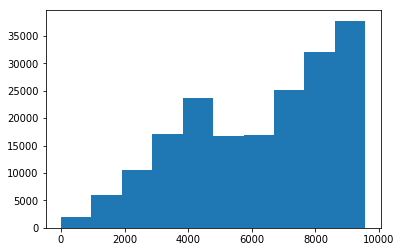

In [20]:
temp=df_CIF2['CUST_START_DT'].dropna(axis=0)
plt.hist(temp)

In [21]:
#教育程度
#計算次數和比例
temp=df_CIF2['EDU_CODE']

freq=pd.crosstab(temp,columns="freq")
freq['percent'] = freq.freq / freq.freq.sum()
freq

col_0,freq,percent
EDU_CODE,,
1.0,1986,0.012515
2.0,20252,0.127619
3.0,67722,0.426754
4.0,28982,0.182632
5.0,23700,0.149347
6.0,16049,0.101134


In [22]:
#收入
#計算次數和比例
temp=df_CIF2['INCOME_RANGE_CODE']

freq=pd.crosstab(temp,columns="freq")
freq['percent'] = freq.freq / freq.freq.sum()
freq

col_0,freq,percent
INCOME_RANGE_CODE,,
1.0,157071,0.838620
2.0,24152,0.128950
3.0,3372,0.018003
4.0,2702,0.014426


In [23]:
#工作月數
#計算次數和比例
temp=df_CIF2['WORK_MTHS']

freq=pd.crosstab(temp,columns="freq")
freq['percent'] = freq.freq / freq.freq.sum()
freq

col_0,freq,percent
WORK_MTHS,,
1.0,142705,0.942016
2.0,8684,0.057324
3.0,86,0.000568
4.0,11,0.000073
5.0,3,0.000020


In [24]:
#計算性別次數和比例
temp=df_CIF2['GENDER_CODE']

freq=pd.crosstab(temp,columns="freq")
freq['percent'] = freq.freq / freq.freq.sum()
freq

col_0,freq,percent
GENDER_CODE,,
F,104885,0.564854
M,80800,0.435146


* 決定CIF補植方式

In [25]:
#缺失值補中位數(平均)
#fillna()補缺失值
#mean()算平均 median()算中位數
#df_data.dropna(axis=0) 這是直接砍na值
#怎麼補年齡值很多方法，可以參考鐵達尼號這個資料庫的討論區
temp=df_CIF2.copy()

temp.AGE.fillna( temp.AGE.median() , inplace=True)
temp.CHILDREN_CNT.fillna( temp.CHILDREN_CNT.median() , inplace=True)
temp.CUST_START_DT.fillna( temp.CUST_START_DT.mean() , inplace=True)
temp.EDU_CODE.fillna( temp.EDU_CODE.median() , inplace=True)
temp.INCOME_RANGE_CODE.fillna( temp.INCOME_RANGE_CODE.median() , inplace=True)
temp.WORK_MTHS.fillna( temp.WORK_MTHS.median() , inplace=True)

#修改性別類型
temp.loc[(temp['GENDER_CODE']=='M') , 'SEX'] = 0 
temp.loc[(temp['GENDER_CODE']=='F') , 'SEX'] = 1
temp.loc[(temp['GENDER_CODE'].isnull()) , 'SEX'] = 99 #性別缺失值不補，以99命名
temp=temp.drop(columns=['GENDER_CODE'])

df_CIF3=temp.copy()

In [26]:
df_CIF2.head()

,CUST_NO,AGE,CHILDREN_CNT,CUST_START_DT,EDU_CODE,GENDER_CODE,INCOME_RANGE_CODE,WORK_MTHS
0,UFUIMEGMK2KTIWI4,1.0,NaN,2.0,NaN,NaN,NaN,NaN
1,3HJN2X_LGBHBKILI,3.0,0.0,9393.0,NaN,NaN,1.0,NaN
2,MNEZK2O3OE-JHYBW,4.0,0.0,2912.0,3.0,M,2.0,2.0
3,W7ADZSWYXEMHB7JQ,4.0,0.0,8332.0,5.0,M,2.0,1.0
4,ODB6BA6ORHL2UYZE,4.0,0.0,744.0,3.0,M,2.0,1.0


In [27]:
df_CIF3.head()

,CUST_NO,AGE,CHILDREN_CNT,CUST_START_DT,EDU_CODE,INCOME_RANGE_CODE,WORK_MTHS,SEX
0,UFUIMEGMK2KTIWI4,1.0,0.0,2.0,3.0,1.0,1.0,99.0
1,3HJN2X_LGBHBKILI,3.0,0.0,9393.0,3.0,1.0,1.0,99.0
2,MNEZK2O3OE-JHYBW,4.0,0.0,2912.0,3.0,2.0,2.0,0.0
3,W7ADZSWYXEMHB7JQ,4.0,0.0,8332.0,5.0,2.0,1.0,0.0
4,ODB6BA6ORHL2UYZE,4.0,0.0,744.0,3.0,2.0,1.0,0.0


# 4.顧客信用卡核卡資料探討

In [28]:
df_CC.head(10)

,CUST_NO,TXN_DT
0,8H_N_K5ICM4NU7OG,9519
1,HXD9GCY3SPIYLJS0,9451
2,KSBOZ-TBPUDD9NMO,9502
3,MU8ROCNFDGSL0HJC,9549
4,RGZZAUSNHNXXESM4,9561
5,RK8IOV3CW0LRIQGA,9546
6,XUNRR-4BPG0AZC6E,9456
7,XHDBEGXDXKLJS8SK,9459
8,XHDBEGXDXKLJS8SK,9459
9,ARREKAB79XDMMPEE,9464


In [29]:
df_CC.describe()

,TXN_DT
count,54393.000000
mean,9506.570864
std,35.295973
min,9448.000000
25%,9473.000000
50%,9508.000000
75%,9536.000000
max,9567.000000


* 共有120天交易資料，取前90天當作訓練參考變項

In [30]:
#共有120天交易資料，取前90天當作訓練參考變項，後30天等等要作為預測Y用的假真值
temp=df_CC.copy()

temp=temp[temp['TXN_DT']<=9537]

df_CC2=temp.copy()

In [31]:
df_CC2.describe()

,TXN_DT
count,41505.000000
mean,9492.153283
std,27.106762
min,9448.000000
25%,9466.000000
50%,9491.000000
75%,9516.000000
max,9537.000000


In [32]:
#計算每個顧客核卡多少次
#value_counts()計算核卡次數
#to_frame()轉成Dataframe形式
#reset_index()重置index，也就是最前面的0、1、2...編號
#rename()變項重新命名{"舊名稱":"新名稱"}
#df_CC.sort_values('TXN_DT')排序(筆記用)
df_CC2=df_CC2.CUST_NO.value_counts().to_frame().reset_index().rename({'CUST_NO':'CC_count', 'index':'CUST_NO'}, axis = 1)

In [33]:
df_CC2.head(10)

,CUST_NO,CC_count
0,KK0M-QMQLWEOAHAE,30
1,LO8DVRNN0AHLD_RC,18
2,FUH-LL7LXGM1NCLS,18
3,5OPZV6UUY8II3TPI,17
4,FSMN6JOJJNQ5D7NO,12
5,QJSM-PEHMKVM3RZ8,12
6,3GIXIFW7MDUH4NLY,12
7,KRXFAQFXWYNLXX5S,12
8,DQH5ZEOWDZC-NW9O,12
9,REEVDTIGNAQJIDYO,12


* 共有120天交易資料，取最後30天當作要作為預測Y用的假真值

In [34]:
#共取最後30天當作要作為預測Y用的假真值
temp=df_CC.copy()

temp=temp[temp['TXN_DT']>9537]

df_CC_Y=temp.copy()

In [35]:
df_CC_Y.describe()

,TXN_DT
count,12888.000000
mean,9553.001785
std,8.139816
min,9538.000000
25%,9547.000000
50%,9554.000000
75%,9560.000000
max,9567.000000


In [36]:
#計算每個顧客核卡多少次
df_CC_Y=df_CC_Y.CUST_NO.value_counts().to_frame().reset_index().rename({'CUST_NO':'Y_CC', 'index':'CUST_NO'}, axis = 1)
df_CC_Y.loc[(df_CC_Y['Y_CC']>0) , 'Y_CC'] = 1

# 5.顧客外匯交易資料

In [37]:
df_FX.head()

,CUST_NO,TXN_DT,FX_TXN_AMT
0,MNEZK2O3OE-JHYBW,9562,26006
1,MNEZK2O3OE-JHYBW,9567,26009
2,MNEZK2O3OE-JHYBW,9557,26793
3,MNEZK2O3OE-JHYBW,9452,25981
4,MNEZK2O3OE-JHYBW,9451,26002


In [38]:
df_FX.describe()

,TXN_DT,FX_TXN_AMT
count,507185.000000,507185.000000
mean,9499.761190,24128.221801
std,36.435846,22243.614667
min,9448.000000,667.000000
25%,9466.000000,5336.000000
50%,9499.000000,17229.000000
75%,9529.000000,35978.000000
max,9567.000000,385877.000000


* 共有120天交易資料，取前90天當作訓練參考變項

In [39]:
#共有120天交易資料，取前90天當作訓練參考變項，後30天等等要作為預測Y用的假真值
temp=df_FX.copy()

temp=temp[temp['TXN_DT']<=9537]

df_FX2=temp.copy()

In [40]:
df_FX2.describe()

,TXN_DT,FX_TXN_AMT
count,417983.000000,417983.000000
mean,9488.069797,24770.240524
std,28.621469,22327.274465
min,9448.000000,667.000000
25%,9463.000000,5374.000000
50%,9483.000000,18587.000000
75%,9515.000000,37352.000000
max,9537.000000,385877.000000


In [41]:
#計算每個顧客交易多少次
df_FX2=df_FX2.CUST_NO.value_counts().to_frame().reset_index().rename({'CUST_NO':'FX_count', 'index':'CUST_NO'}, axis = 1)

* 共有120天交易資料，取最後30天當作要作為預測Y用的假真值

In [42]:
#共取最後30天當作要作為預測Y用的假真值
temp=df_FX.copy()

temp=temp[temp['TXN_DT']>9537]

df_FX_Y=temp.copy()

In [43]:
df_FX_Y.describe()

,TXN_DT,FX_TXN_AMT
count,89202.000000,89202.000000
mean,9554.544752,21119.848535
std,8.246865,21594.664585
min,9538.000000,733.000000
25%,9548.000000,5230.000000
50%,9555.000000,13423.000000
75%,9562.000000,29862.750000
max,9567.000000,336630.000000


In [44]:
#計算每個顧客交易次數
df_FX_Y=df_FX_Y.CUST_NO.value_counts().to_frame().reset_index().rename({'CUST_NO':'Y_FX', 'index':'CUST_NO'}, axis = 1)
df_FX_Y.loc[(df_FX_Y['Y_FX']>0) , 'Y_FX'] = 1

In [45]:
df_FX_Y.head()

,CUST_NO,Y_FX
0,ZHIWV-JNCG012YOC,1
1,A1EVOFLRY9NCTAWA,1
2,BR2FK8RIO8ASNGKI,1
3,YFREQTBCF6K6DZNQ,1
4,IL55KVYTJCP8W2_0,1


# 6.顧客信貸申請資料

In [46]:
df_LN.head()

,CUST_NO,TXN_DT,LN_AMT,LN_USE
0,JZKEGB1J3FEPXGWA,9455,904731,06
1,TKTH9UXLWDVLA8E4,9472,1218170,01
2,KZ0XPLZI-NGTHTDE,9505,1183088,01
3,BT5INBWYOZQK8CDY,9457,848097,05
4,Z5H7IUX8VPUMWWY8,9473,848097,01


* 共有120天交易資料，取前90天當作訓練參考變項

In [47]:
#共有120天交易資料，取前90天當作訓練參考變項，後30天等等要作為預測Y用的假真值
temp=df_LN.copy()

temp=temp[temp['TXN_DT']<=9537]

df_LN2=temp.copy()

In [48]:
df_LN2.describe()

,TXN_DT,LN_AMT
count,4900.000000,4.900000e+03
mean,9492.958776,8.869012e+05
std,27.473120,9.273783e+04
min,9449.000000,1.000000e+05
25%,9469.000000,8.288640e+05
50%,9490.000000,8.794830e+05
75%,9519.000000,9.259660e+05
max,9537.000000,1.218170e+06


In [49]:
#計算每個顧客交易多少次
df_LN2=df_LN2.CUST_NO.value_counts().to_frame().reset_index().rename({'CUST_NO':'LN_count', 'index':'CUST_NO'}, axis = 1)

* 共有120天交易資料，取最後30天當作要作為預測Y用的假真值

In [50]:
#共取最後30天當作要作為預測Y用的假真值
temp=df_LN.copy()

temp=temp[temp['TXN_DT']>9537]

df_LN_Y=temp.copy()

In [51]:
df_LN_Y.describe()

,TXN_DT,LN_AMT
count,1841.000000,1.841000e+03
mean,9554.042368,9.178195e+05
std,7.458679,1.176930e+05
min,9539.000000,7.394370e+05
25%,9548.000000,8.480970e+05
50%,9554.000000,9.047310e+05
75%,9561.000000,9.884950e+05
max,9567.000000,1.218170e+06


In [52]:
#計算每個顧客交易次數
df_LN_Y=df_LN_Y.CUST_NO.value_counts().to_frame().reset_index().rename({'CUST_NO':'Y_LN', 'index':'CUST_NO'}, axis = 1)
df_LN_Y.loc[(df_LN_Y['Y_LN']>0) , 'Y_LN'] = 1

In [53]:
df_LN_Y.head()

,CUST_NO,Y_LN
0,JSEVG1UTPNDCNZJA,1
1,5CXECBCTNRW8HGW0,1
2,6IGLOCHDUA6J0MS4,1
3,7CLREAHBDB7J_OPW,1
4,OBBAXZVH6QS0LVKS,1


# 7.顧客信託類產品交易資料

In [54]:
df_WM.head()

,CUST_NO,TXN_DT,CUST_RISK_CODE,INVEST_TYPE_CODE,WM_TXN_AMT
0,83A1N8HQ4CLT56IY,9476,3.0,2,270684
1,B8ZNLMVWJOHCJ7LY,9546,3.0,2,254794
2,-O2NVMT-W0WJHEAQ,9521,3.0,2,797298
3,NRVZ15KRUYBNVLX0,9490,4.0,2,439191
4,GAP3CQTQ-3K8OAHM,9513,4.0,2,137037


* 共有120天交易資料，取前90天當作訓練參考變項

In [55]:
#共有120天交易資料，取前90天當作訓練參考變項，後30天等等要作為預測Y用的假真值
temp=df_WM.copy()

temp=temp[temp['TXN_DT']<=9537]

df_WM2=temp.copy()

In [56]:
df_WM2.describe()

,TXN_DT,CUST_RISK_CODE,INVEST_TYPE_CODE,WM_TXN_AMT
count,28177.000000,28090.000000,28177.000000,2.817700e+04
mean,9491.068247,3.724279,1.224580,6.489648e+05
std,25.502790,0.491790,0.417313,3.787795e+05
min,9449.000000,1.000000,1.000000,2.636000e+04
25%,9470.000000,3.000000,1.000000,4.391910e+05
50%,9487.000000,4.000000,1.000000,5.718850e+05
75%,9513.000000,4.000000,1.000000,7.972980e+05
max,9537.000000,4.000000,2.000000,6.608125e+06


In [57]:
#計算每個顧客交易多少次
df_WM2=df_WM2.CUST_NO.value_counts().to_frame().reset_index().rename({'CUST_NO':'WM_count', 'index':'CUST_NO'}, axis = 1)

* 共有120天交易資料，取最後30天當作要作為預測Y用的假真值

In [58]:
#共取最後30天當作要作為預測Y用的假真值
temp=df_WM.copy()

temp=temp[temp['TXN_DT']>9537]

df_WM_Y=temp.copy()

In [59]:
df_WM_Y.describe()

,TXN_DT,CUST_RISK_CODE,INVEST_TYPE_CODE,WM_TXN_AMT
count,8586.000000,8586.000000,8586.000000,8.586000e+03
mean,9553.583042,3.643606,1.165968,7.948363e+05
std,7.035854,0.541083,0.372073,4.572161e+05
min,9539.000000,1.000000,1.000000,1.000000e+04
25%,9548.000000,3.000000,1.000000,4.688320e+05
50%,9553.000000,4.000000,1.000000,6.716840e+05
75%,9560.000000,4.000000,1.000000,1.061490e+06
max,9567.000000,4.000000,2.000000,3.167233e+06


In [60]:
#計算每個顧客交易次數
df_WM_Y=df_WM_Y.CUST_NO.value_counts().to_frame().reset_index().rename({'CUST_NO':'Y_WM', 'index':'CUST_NO'}, axis = 1)
df_WM_Y.loc[(df_WM_Y['Y_WM']>0) , 'Y_WM'] = 1

In [61]:
df_WM_Y.head()

,CUST_NO,Y_WM
0,BU5AGBHXXHW8B-7Q,1
1,BAHQ1X9NAJ2DBZFM,1
2,O6PD9JEDV4JG9ZUA,1
3,G_0CXIOI2PLY4V5U,1
4,FJQHMBFTSRUNHPL4,1


# 8.顧客瀏覽行為

In [62]:
df_BE.head()

,CUST_NO,VISITDATE,PAGE
0,AZTHNWQ_LXMGIMYG,9462,http://www.esunbank.com.tw/gygrt/e2c/iougkjr/
1,AZTHNWQ_LXMGIMYG,9528,https://www.esunbank.com.tw/gygrt/wgdqth/gsxri...
2,3PY428CHUQBULFIG,9458,https://www.esunbank.com.tw/edrn/deoxt/rgws-cg...
3,JVPD1QUJWVLMZU8S,9457,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...
4,JVPD1QUJWVLMZU8S,9485,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...


In [63]:
#將網址分割
#df_BE2=df_BE['PAGE'].str.split('/',expand=True)
df_BE2=pd.merge(df_BE,pd.DataFrame(df_BE['PAGE'].str.split('/',expand=True)),how='left',left_index=True,right_index=True)

In [64]:
pd.value_counts(df_BE2[3])

edrn      1807177
gygrt      297029
s          103775
gpda         1698
fgmo          177
wgdqth          8
Name: 3, dtype: int64

In [65]:
df_BE2.head(3)

,CUST_NO,VISITDATE,PAGE,0,1,2,3,4,5,6,7,8,9
0,AZTHNWQ_LXMGIMYG,9462,http://www.esunbank.com.tw/gygrt/e2c/iougkjr/,http:,,www.esunbank.com.tw,gygrt,e2c,iougkjr,,None,None,None
1,AZTHNWQ_LXMGIMYG,9528,https://www.esunbank.com.tw/gygrt/wgdqth/gsxri...,https:,,www.esunbank.com.tw,gygrt,wgdqth,gsxrioof,,None,None,None
2,3PY428CHUQBULFIG,9458,https://www.esunbank.com.tw/edrn/deoxt/rgws-cg...,https:,,www.esunbank.com.tw,edrn,deoxt,rgws-cgrtgu,None,None,None,None


In [66]:
#重新命名變項名稱
df_BE2.rename(columns={3:'url'},index=str,inplace=True)

In [67]:
#只抓出想要的變項
df_BE3 = df_BE2[['CUST_NO','url']]

In [68]:
df_BE3.head(5)

,CUST_NO,url
0,AZTHNWQ_LXMGIMYG,gygrt
1,AZTHNWQ_LXMGIMYG,gygrt
2,3PY428CHUQBULFIG,edrn
3,JVPD1QUJWVLMZU8S,edrn
4,JVPD1QUJWVLMZU8S,edrn


In [69]:
#查看這個變項有什麼類別
df_BE3['url'].unique()

array(['gygrt', 'edrn', 's', 'gpda', 'fgmo', 'wgdqth'], dtype=object)

In [70]:
#算次數並轉置
tmp = df_BE3.groupby(['CUST_NO','url']).size().to_frame().reset_index().pivot(index = 'CUST_NO', columns = 'url')
tmp.columns = tmp.columns.droplevel()
tmp.reset_index()
df_BE4=tmp.copy()
df_BE4.head()

url,edrn,fgmo,gpda,gygrt,s,wgdqth
CUST_NO,,,,,,
---CHVW7DUN8SZLO,14.0,NaN,NaN,1.0,NaN,NaN
--1YNJZSSOXDF6UU,3.0,NaN,NaN,6.0,NaN,NaN
--2YJM1RA5I5NQBC,1.0,NaN,NaN,NaN,NaN,NaN
--3HR4AMZR7EWEKS,NaN,NaN,NaN,2.0,NaN,NaN
--3NF5SUEEEAWOPI,27.0,NaN,NaN,1.0,NaN,NaN


# 9.跑模型前最後整理

In [71]:
#跟顧客基本資料合併
#merge
tmp=df_CIF3.copy() #顧客基本資料

#前90天的資料
tmp=pd.merge(tmp,df_CC2,how='left', on='CUST_NO') #信用卡
tmp=pd.merge(tmp,df_FX2,how='left', on='CUST_NO') #顧客外匯交易資料
tmp=pd.merge(tmp,df_LN2,how='left', on='CUST_NO') #顧客信貸申請資料
tmp=pd.merge(tmp,df_WM2,how='left', on='CUST_NO') #顧客信託類產品交易資料
tmp=pd.merge(tmp,df_BE4,how='left', on='CUST_NO') #網頁瀏覽

#依後30天假設的真值
tmp=pd.merge(tmp,df_CC_Y,how='left', on='CUST_NO') #信用卡
tmp=pd.merge(tmp,df_FX_Y,how='left', on='CUST_NO') #顧客外匯交易資料
tmp=pd.merge(tmp,df_LN_Y,how='left', on='CUST_NO') #顧客信貸申請資料
tmp=pd.merge(tmp,df_WM_Y,how='left', on='CUST_NO') #顧客信託類產品交易資料

df_CIF4=tmp.copy()
df_CIF4.head(10)

,CUST_NO,AGE,CHILDREN_CNT,CUST_START_DT,EDU_CODE,INCOME_RANGE_CODE,WORK_MTHS,SEX,CC_count,FX_count,...,edrn,fgmo,gpda,gygrt,s,wgdqth,Y_CC,Y_FX,Y_LN,Y_WM
0,UFUIMEGMK2KTIWI4,1.0,0.0,2.0,3.0,1.0,1.0,99.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3HJN2X_LGBHBKILI,3.0,0.0,9393.0,3.0,1.0,1.0,99.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MNEZK2O3OE-JHYBW,4.0,0.0,2912.0,3.0,2.0,2.0,0.0,NaN,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
3,W7ADZSWYXEMHB7JQ,4.0,0.0,8332.0,5.0,2.0,1.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ODB6BA6ORHL2UYZE,4.0,0.0,744.0,3.0,2.0,1.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,SURN2CDMNHCL4SJC,4.0,0.0,4677.0,2.0,2.0,1.0,0.0,NaN,17.0,...,28.0,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN
6,1SMBYIP5SSUNG1DW,4.0,0.0,7936.0,6.0,1.0,1.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8H_N_K5ICM4NU7OG,4.0,0.0,3502.0,3.0,1.0,2.0,0.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,OGMWH3NPW4BKLRBU,4.0,0.0,5418.0,3.0,2.0,1.0,0.0,NaN,NaN,...,27.0,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN
9,XKLJ6BLFOZE-QWES,4.0,0.0,4674.0,4.0,2.0,1.0,0.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
#NaN值補0
tmp=df_CIF4.copy()
tmp.loc[(tmp['CC_count'].isnull()) , 'CC_count'] = 0 
tmp.loc[(tmp['FX_count'].isnull()) , 'FX_count'] = 0 
tmp.loc[(tmp['LN_count'].isnull()) , 'LN_count'] = 0 
tmp.loc[(tmp['WM_count'].isnull()) , 'WM_count'] = 0 

tmp.loc[(tmp['edrn'].isnull()) , 'edrn'] = 0 
tmp.loc[(tmp['fgmo'].isnull()) , 'fgmo'] = 0 
tmp.loc[(tmp['gpda'].isnull()) , 'gpda'] = 0 
tmp.loc[(tmp['gygrt'].isnull()) , 'gygrt'] = 0 
tmp.loc[(tmp['s'].isnull()) , 's'] = 0 
tmp.loc[(tmp['wgdqth'].isnull()) , 'wgdqth'] = 0 

#假真值
tmp.loc[(tmp['Y_CC'].isnull()) , 'Y_CC'] = 0 
tmp.loc[(tmp['Y_FX'].isnull()) , 'Y_FX'] = 0 
tmp.loc[(tmp['Y_LN'].isnull()) , 'Y_LN'] = 0 
tmp.loc[(tmp['Y_WM'].isnull()) , 'Y_WM'] = 0 

df_CIF5=tmp.copy()
df_CIF5.head(10)

,CUST_NO,AGE,CHILDREN_CNT,CUST_START_DT,EDU_CODE,INCOME_RANGE_CODE,WORK_MTHS,SEX,CC_count,FX_count,...,edrn,fgmo,gpda,gygrt,s,wgdqth,Y_CC,Y_FX,Y_LN,Y_WM
0,UFUIMEGMK2KTIWI4,1.0,0.0,2.0,3.0,1.0,1.0,99.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3HJN2X_LGBHBKILI,3.0,0.0,9393.0,3.0,1.0,1.0,99.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,MNEZK2O3OE-JHYBW,4.0,0.0,2912.0,3.0,2.0,2.0,0.0,0.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,W7ADZSWYXEMHB7JQ,4.0,0.0,8332.0,5.0,2.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ODB6BA6ORHL2UYZE,4.0,0.0,744.0,3.0,2.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,SURN2CDMNHCL4SJC,4.0,0.0,4677.0,2.0,2.0,1.0,0.0,0.0,17.0,...,28.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1SMBYIP5SSUNG1DW,4.0,0.0,7936.0,6.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8H_N_K5ICM4NU7OG,4.0,0.0,3502.0,3.0,1.0,2.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,OGMWH3NPW4BKLRBU,4.0,0.0,5418.0,3.0,2.0,1.0,0.0,0.0,0.0,...,27.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0
9,XKLJ6BLFOZE-QWES,4.0,0.0,4674.0,4.0,2.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
df_CIF5.isna().sum() #計算每個有幾筆colum缺失值

CUST_NO              0
AGE                  0
CHILDREN_CNT         0
CUST_START_DT        0
EDU_CODE             0
INCOME_RANGE_CODE    0
WORK_MTHS            0
SEX                  0
CC_count             0
FX_count             0
LN_count             0
WM_count             0
edrn                 0
fgmo                 0
gpda                 0
gygrt                0
s                    0
wgdqth               0
Y_CC                 0
Y_FX                 0
Y_LN                 0
Y_WM                 0
dtype: int64

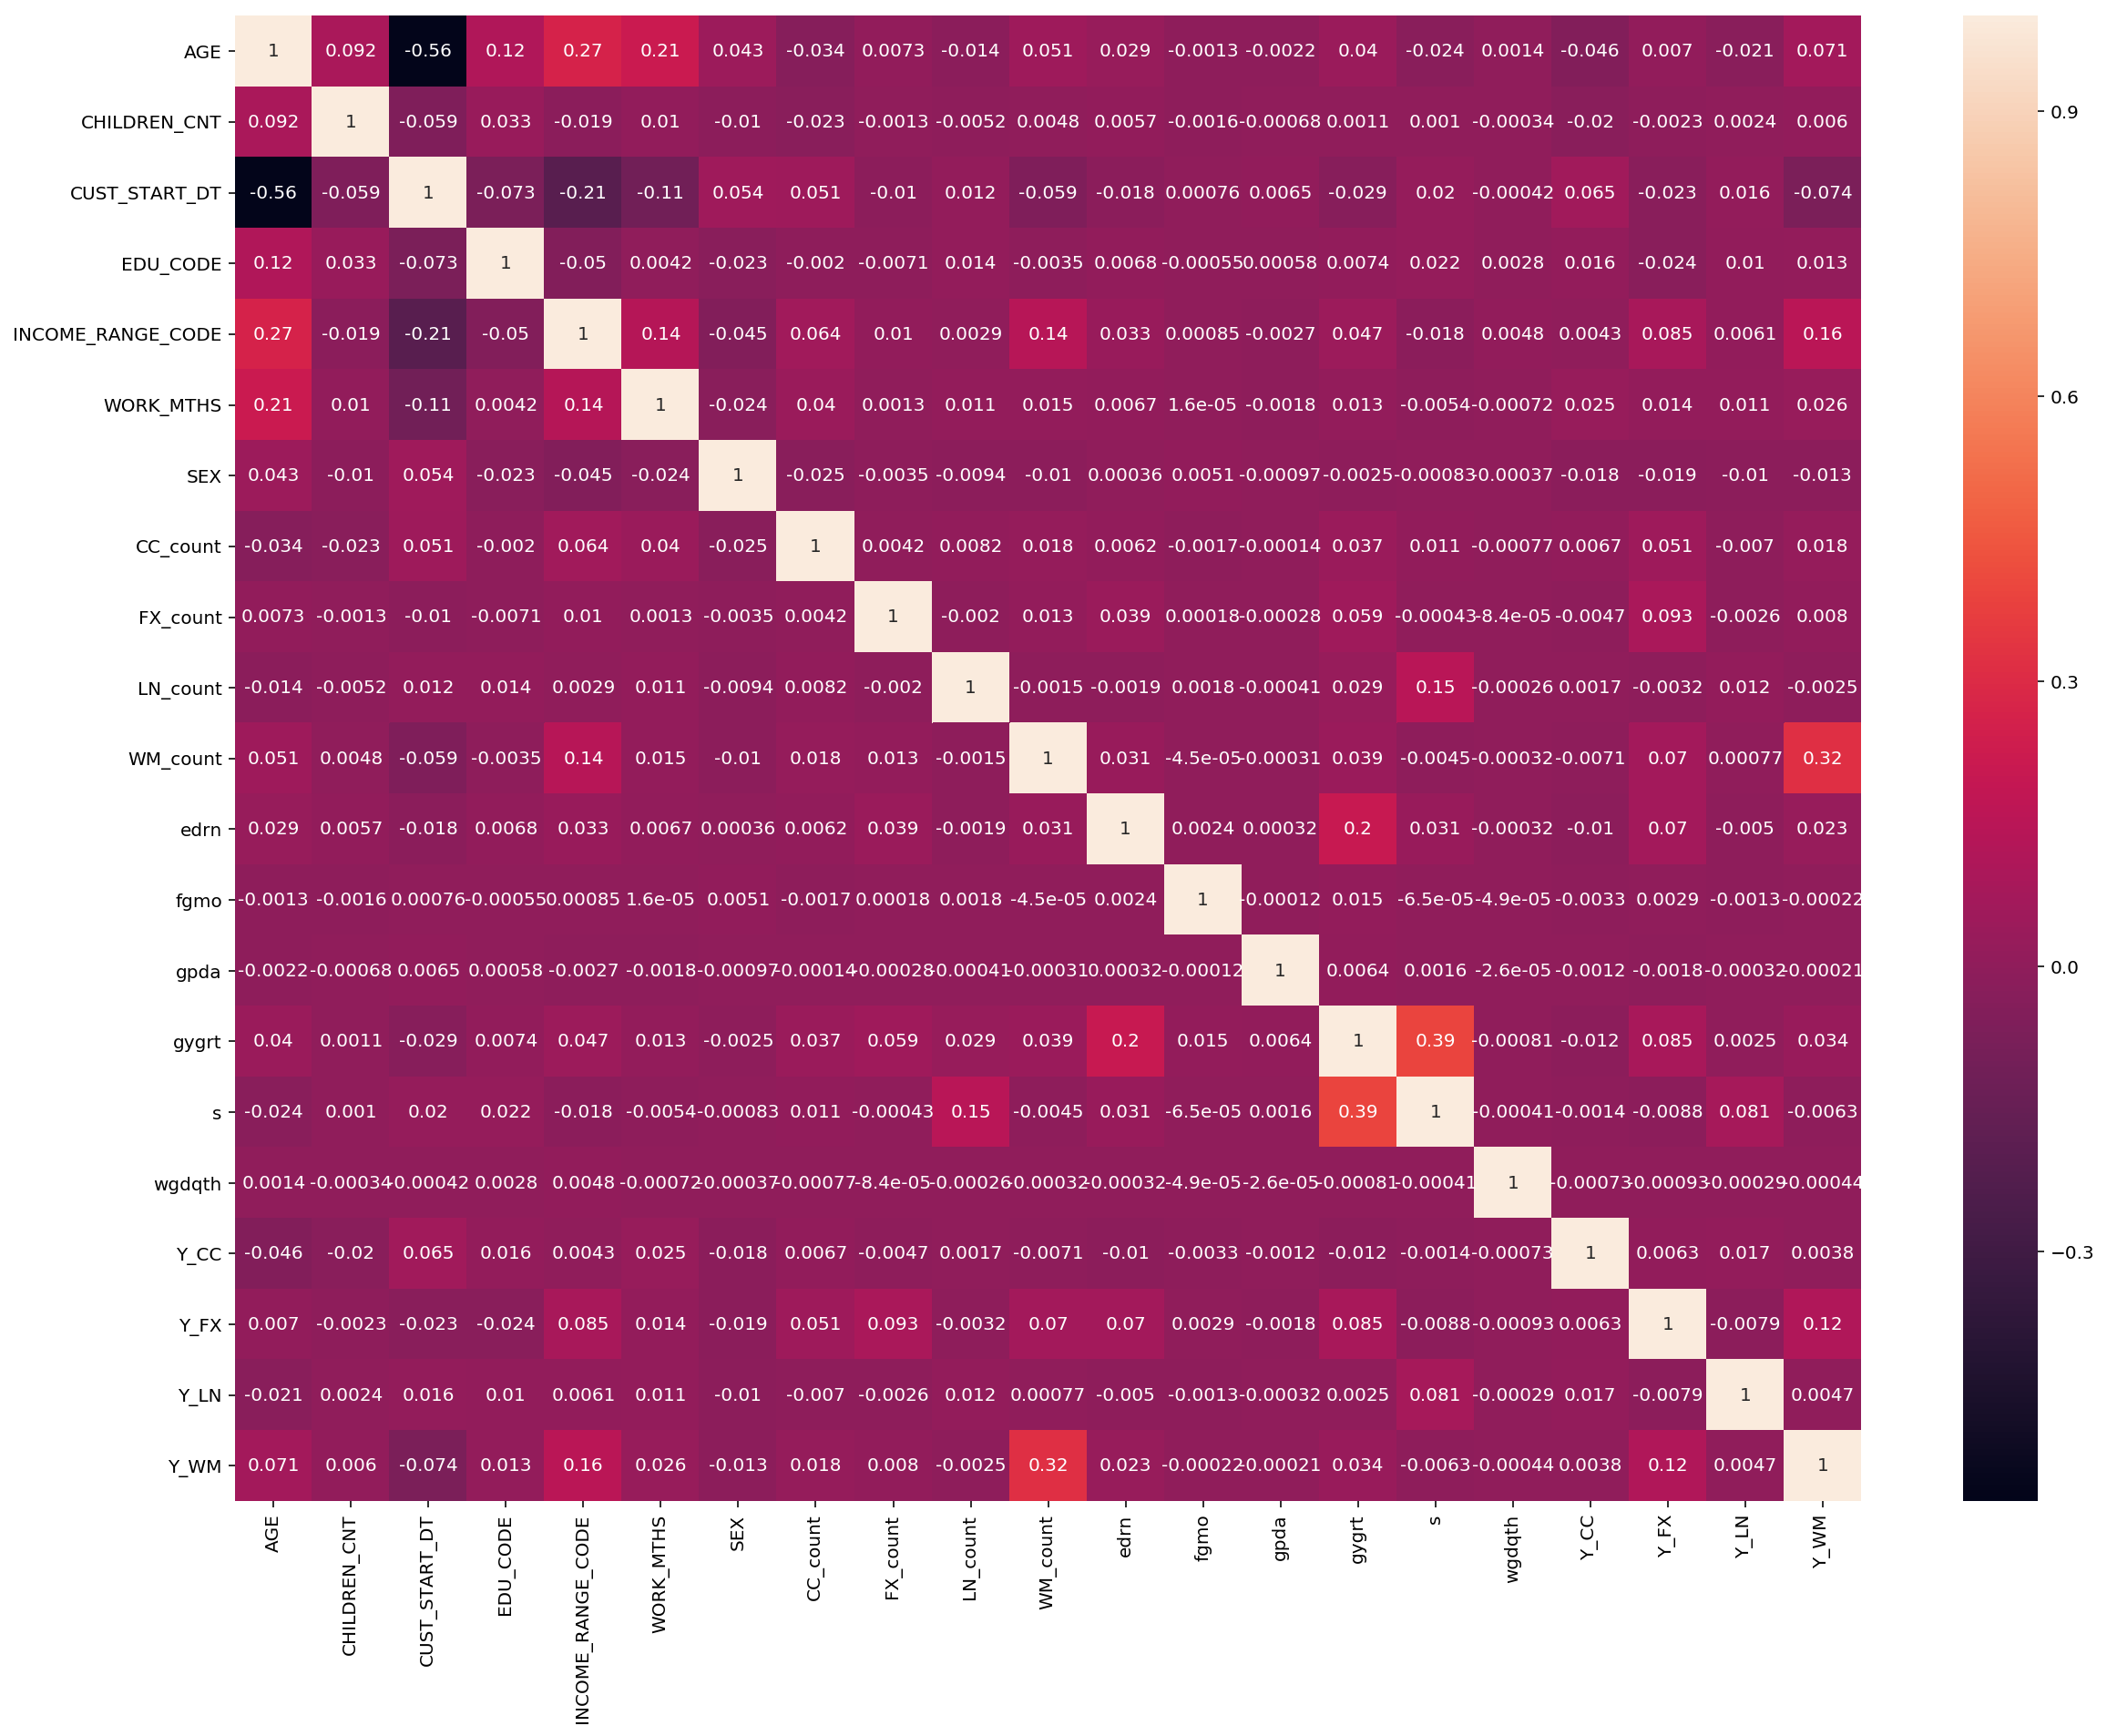

In [74]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15),dpi=144)  #設置畫布大小和辨識率

corr = df_CIF5.corr()
sns.heatmap(corr, annot=True)

# 進行模型訓練

In [75]:
df_CIF5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187825 entries, 0 to 187824
Data columns (total 22 columns):
CUST_NO              187825 non-null object
AGE                  187825 non-null float64
CHILDREN_CNT         187825 non-null float64
CUST_START_DT        187825 non-null float64
EDU_CODE             187825 non-null float64
INCOME_RANGE_CODE    187825 non-null float64
WORK_MTHS            187825 non-null float64
SEX                  187825 non-null float64
CC_count             187825 non-null float64
FX_count             187825 non-null float64
LN_count             187825 non-null float64
WM_count             187825 non-null float64
edrn                 187825 non-null float64
fgmo                 187825 non-null float64
gpda                 187825 non-null float64
gygrt                187825 non-null float64
s                    187825 non-null float64
wgdqth               187825 non-null float64
Y_CC                 187825 non-null float64
Y_FX                 187825 non-nul

In [76]:
### 切出 訓練的X和Y
#預測的
TRY=['Y_CC']
FINY=['CC_CC']

#要放的變項
keep=['AGE','CHILDREN_CNT','CUST_START_DT','EDU_CODE','INCOME_RANGE_CODE','WORK_MTHS','SEX',
      'CC_count','FX_count','LN_count','WM_count','edrn','fgmo','gpda','gygrt','s','wgdqth']

X = df_CIF5[keep]
Y = df_CIF5[TRY]

# 切分訓練集及測試集
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# 選擇模型
from sklearn import ensemble 
model = ensemble.RandomForestClassifier()

# 訓練
model.fit(X_train, Y_train)
pred = model.predict(X_test)



#讀取最後要預測的ID檔
df_zero2=df_zero['CUST_NO'].to_frame() #只保留ID變項

#挑選出要預測ID的人
tmp=df_CIF5.copy()
df_zero3=pd.merge(df_zero2,tmp,how='left',on='CUST_NO')

#要放的變項
keep=['AGE','CHILDREN_CNT','CUST_START_DT','EDU_CODE','INCOME_RANGE_CODE','WORK_MTHS','SEX',
      'CC_count','FX_count','LN_count','WM_count','edrn','fgmo','gpda','gygrt','s','wgdqth']

temp = df_zero3[keep]

#預測
result = model.predict(temp)

# #合回ID
# result = pd.DataFrame(result, columns = [FINY])
# result[FINY] = result[FINY].astype(int) #轉成整數型態
# result["CUST_NO"] = df_zero3.CUST_NO

result_CC=result.copy()

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [77]:
### 切出 訓練的X和Y
#預測的
TRY=['Y_FX']
FINY=['CC_FX']

#要放的變項
keep=['AGE','CHILDREN_CNT','CUST_START_DT','EDU_CODE','INCOME_RANGE_CODE','WORK_MTHS','SEX',
      'CC_count','FX_count','LN_count','WM_count','edrn','fgmo','gpda','gygrt','s','wgdqth']

X = df_CIF5[keep]
Y = df_CIF5[TRY]

# 切分訓練集及測試集
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# 選擇模型
from sklearn import ensemble 
model = ensemble.RandomForestClassifier()

# 訓練
model.fit(X_train, Y_train)
pred = model.predict(X_test)



#讀取最後要預測的ID檔
df_zero2=df_zero['CUST_NO'].to_frame() #只保留ID變項

#挑選出要預測ID的人
tmp=df_CIF5.copy()
df_zero3=pd.merge(df_zero2,tmp,how='left',on='CUST_NO')

#要放的變項
keep=['AGE','CHILDREN_CNT','CUST_START_DT','EDU_CODE','INCOME_RANGE_CODE','WORK_MTHS','SEX',
      'CC_count','FX_count','LN_count','WM_count','edrn','fgmo','gpda','gygrt','s','wgdqth']

temp = df_zero3[keep]

#預測
result = model.predict(temp)

# #合回ID
# result = pd.DataFrame(result, columns = [FINY])
# result[FINY] = result[FINY].astype(int) #轉成整數型態
# result["CUST_NO"] = df_zero3.CUST_NO

result_FX=result.copy()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [78]:
### 切出 訓練的X和Y
#預測的
TRY=['Y_LN']
FINY=['CC_LN']

#要放的變項
keep=['AGE','CHILDREN_CNT','CUST_START_DT','EDU_CODE','INCOME_RANGE_CODE','WORK_MTHS','SEX',
      'CC_count','FX_count','LN_count','WM_count','edrn','fgmo','gpda','gygrt','s','wgdqth']

X = df_CIF5[keep]
Y = df_CIF5[TRY]

# 切分訓練集及測試集
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# 選擇模型
from sklearn import ensemble 
model = ensemble.RandomForestClassifier()

# 訓練
model.fit(X_train, Y_train)
pred = model.predict(X_test)



#讀取最後要預測的ID檔
df_zero2=df_zero['CUST_NO'].to_frame() #只保留ID變項

#挑選出要預測ID的人
tmp=df_CIF5.copy()
df_zero3=pd.merge(df_zero2,tmp,how='left',on='CUST_NO')

#要放的變項
keep=['AGE','CHILDREN_CNT','CUST_START_DT','EDU_CODE','INCOME_RANGE_CODE','WORK_MTHS','SEX',
      'CC_count','FX_count','LN_count','WM_count','edrn','fgmo','gpda','gygrt','s','wgdqth']

temp = df_zero3[keep]

#預測
result = model.predict(temp)

# #合回ID
# result = pd.DataFrame(result, columns = [FINY])
# result[FINY] = result[FINY].astype(int) #轉成整數型態
# result["CUST_NO"] = df_zero3.CUST_NO

result_LN=result.copy()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [79]:
### 切出 訓練的X和Y
#預測的
TRY=['Y_WM']
FINY=['CC_WM']

#要放的變項
keep=['AGE','CHILDREN_CNT','CUST_START_DT','EDU_CODE','INCOME_RANGE_CODE','WORK_MTHS','SEX',
      'CC_count','FX_count','LN_count','WM_count','edrn','fgmo','gpda','gygrt','s','wgdqth']

X = df_CIF5[keep]
Y = df_CIF5[TRY]

# 切分訓練集及測試集
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# 選擇模型
from sklearn import ensemble 
model = ensemble.RandomForestClassifier()

# 訓練
model.fit(X_train, Y_train)
pred = model.predict(X_test)



#讀取最後要預測的ID檔
df_zero2=df_zero['CUST_NO'].to_frame() #只保留ID變項

#挑選出要預測ID的人
tmp=df_CIF5.copy()
df_zero3=pd.merge(df_zero2,tmp,how='left',on='CUST_NO')

#要放的變項
keep=['AGE','CHILDREN_CNT','CUST_START_DT','EDU_CODE','INCOME_RANGE_CODE','WORK_MTHS','SEX',
      'CC_count','FX_count','LN_count','WM_count','edrn','fgmo','gpda','gygrt','s','wgdqth']

temp = df_zero3[keep]

#預測
result = model.predict(temp)

# #合回ID
# result = pd.DataFrame(result, columns = [FINY])
# result[FINY] = result[FINY].astype(int) #轉成整數型態
# result["CUST_NO"] = df_zero3.CUST_NO

result_WM=result.copy()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [81]:
ln = pd.read_csv('tbrain.csv')
ln['LN_IND'].value_counts()
ln.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 1 columns):
LN_IND    30000 non-null float64
dtypes: float64(1)
memory usage: 234.5 KB


In [82]:
df_zero2.shape

(30000, 1)

# 合成輸出報表

In [83]:
result_CC = pd.DataFrame(result_CC, columns = ['CC_IND'])
result_FX = pd.DataFrame(result_FX, columns = ['FX_IND'])
#result_LN = pd.DataFrame(ln, columns = ['LN_IND'])
result_WM = pd.DataFrame(result_WM, columns = ['WM_IND'])

In [129]:
#預測結果合併
#merge
temp=df_zero2.copy() #以信用卡為基底

temp = pd.merge(temp, result_CC, left_index=True, right_index=True)
temp = pd.merge(temp, result_FX, left_index=True, right_index=True)
temp = pd.merge(temp, df_predict, left_index=True, right_index=True)
temp = pd.merge(temp, result_WM, left_index=True, right_index=True)

FINAL=temp.copy()
FINAL.head(10)

,CUST_NO,CC_IND,FX_IND,LN_IND,WM_IND
0,_PT5HFBEZJKOZ934,0.0,0.0,0.0,0.0
1,6STXUMWZRDCGSDDU,0.0,0.0,0.0,0.0
2,JDVF4U8JUANEID68,0.0,0.0,0.0,0.0
3,8I6SQDGP9OQYUN1M,0.0,0.0,0.0,0.0
4,R-TRDUV3GHTID31I,0.0,0.0,0.0,0.0
5,J0DDOZLDFF03QBKW,0.0,0.0,0.0,0.0
6,HWAZJ_IO2-GACG_C,0.0,0.0,0.0,0.0
7,TREOAHKDWDKDT3UQ,0.0,0.0,0.0,0.0
8,SA1L7XU6FBENQNT8,0.0,0.0,0.0,0.0
9,K0RCWGLXIKGPZNCI,0.0,0.0,0.0,0.0


In [130]:
#製成結果報表
FINAL.to_csv('TBN_Y_ZERO.csv', index = False)

In [131]:
FINAL.isna().sum()

CUST_NO    0
CC_IND     0
FX_IND     0
LN_IND     0
WM_IND     0
dtype: int64

In [132]:
pd.unique(df_predict['LN_IND'])

array([0., 1.])